# EAD

In [9]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette("BuGn_r", n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [10]:
feeding_details_22 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_22 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_23 = pd.read_csv("datasets/2023-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_23 = pd.read_csv("datasets/2023-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_24 = pd.read_csv("datasets/2024-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_24 = pd.read_csv("datasets/2024-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_25 = pd.read_csv("datasets/2025-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_25 = pd.read_csv("datasets/2025-feeding-tasks.csv", on_bad_lines="skip")

monthly_feeding = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Feeding")
herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
production_indicators = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Dairy indicators").replace("-", np.nan)

In [31]:
def merge_tables() -> pd.DataFrame:
    """
    Merges all feeding dataframes with all details dataframes
    returns: merged dataframe
    rtype: pd.DataFrame
    """
    feeding_22["year"] = "2022"
    feeding_23["year"] = "2023"
    feeding_24["year"] = "2024"
    feeding_25["year"] = "2025"
    feeding_details_22["year"] = "2022"
    feeding_details_23["year"] = "2023"
    feeding_details_24["year"] = "2024"
    feeding_details_25["year"] = "2025"

    feeding_all = pd.concat([feeding_22, feeding_23, feeding_24, feeding_25], ignore_index=True)
    feeding_details_all = pd.concat([feeding_details_22, feeding_details_23, feeding_details_24, feeding_details_25], ignore_index=True)
    
    return feeding_all.merge(feeding_details_all, on=["FeedingTaskID", "SectionID", "year", "PhysiologicalGroupID", "PhysiologicalGroupName"], how="left")

In [32]:
feeding_and_details = merge_tables()

## Должно быть 16,411,365 строк

## Описание данных

- feeding-task - все описание кормления по фермам + секциям + группе животного
- detais - хз пока что чем отличаются details от просто feeding-task, мб тут как то поочередно загружаются ингредиенты, потом посмотрим еще
- monthly-feeding - тут название какого-то пресета кормления и распределение по времени на группу животных на конкретной ферме, пока что хз что за пресеты и где их найти
- herd-metrics - стадо, там тоже есть количество молока(это исследуемая переменная)
- production-indicators - ферма там количество коров разных типов, разделенных по группам и количество молока - или это исследуемая переменная(скорее всего)

> Тут будем действовать от того, как построим исследовательский вопрос, нужно понять как лучше исследовать, по ферме или по стаду, изначально мне кажется 2, поскольку больше переменных по которым можно смотреть переменную интереса
---

## Пример Исследовательских вопросов:
- Как какой-то тип питания (допустим разнообразное питание) влияет на аппетит и следовательно качество дойки коров? $\rightarrow$ Скорее всего придется группировать данные по питанию, жестко изучать, какие корма что означают, чтобы понять что означает разнообразное питание. Если тяжело, можно проанализировать добавки в пищу и их количество, понять как они влияют на аппетит и качество дойки.
- Можно попробовать сделать что то с заболеваниями коров, но насколько я понял, заболевших коров достаточно мало, это может быть безрезультативно. (я не склоняюсь к этому варианту)
- Как изменение количества основных ингредиентов в рационе отражается на аппетите и продуктивности дойных коров в разных физиологических группах? - что то интересное, тут 50/50, может полуиться, может  полностью ничего не найтись
> Итого я склоняюсь к 1 исследовательскому вопросу, он выглядит как наиболее возможный
---

## Распределения

In [15]:
production_indicators

,date,region,prod_farm_name,farm_type,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num
0,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2878.0,2609.0,69.0,2094.0,340.0,106.0,34.1,86551.0,0.0,NaN,NaN,NaN,NaN,NaN,23.0
1,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2882.0,2591.0,131.0,2149.0,261.0,50.0,36.3,88816.0,68.0,NaN,NaN,NaN,NaN,NaN,18.0
2,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2893.0,2580.0,101.0,2104.0,375.0,0.0,38.3,98563.0,85.0,NaN,NaN,NaN,NaN,NaN,0.0
3,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2885.0,2686.0,90.0,2271.0,163.0,162.0,35.2,87647.0,153.0,NaN,NaN,NaN,NaN,NaN,26.0
4,2022-12-01,Воронеж,ЭНА Восток,МТФ,МТФ ЭНАВ,799.0,738.0,8.0,507.0,0.0,223.0,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,5882.0,5468.0,169.0,4455.0,288.0,556.0,36.0,191276.0,526.0,0.0,14.0,33.0,13.0,26.0,0.0
1743,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4666.0,4172.0,304.0,3023.0,559.0,286.0,36.7,147218.0,189.0,48.0,23.0,24.0,19.0,24.0,12.0
1744,2025-07-01,Сибирь,Сибирская Нива Маслянино,РМ,РМ Пеньково,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,164.0
1745,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3544.0,3140.0,214.0,1842.0,1027.0,57.0,40.4,119264.0,115.0,21.0,18.0,20.0,20.0,11.0,10.0


In [16]:
production_indicators["weekly_milking_per_cow"].isna().sum() / production_indicators.shape[0]

np.float64(0.25701202060675443)

In [17]:
farm_milk = production_indicators[production_indicators["milk_cows"] > 0]
farm_milk

,date,region,prod_farm_name,farm_type,farm_name,cows_total,milk_cows,milk_cows_d0,milk_cows_d1,milk_cows_d2,milk_cows_d3,weekly_milking_per_cow,gross_milk_yield,cow_retired,cow_retired_low_prod,cow_retired_hooves,cow_retired_inj_joint,cow_retired_mastit,cow_retired_jkt,bull_num
0,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2878.0,2609.0,69.0,2094.0,340.0,106.0,34.1,86551.0,0.0,NaN,NaN,NaN,NaN,NaN,23.0
1,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2882.0,2591.0,131.0,2149.0,261.0,50.0,36.3,88816.0,68.0,NaN,NaN,NaN,NaN,NaN,18.0
2,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2893.0,2580.0,101.0,2104.0,375.0,0.0,38.3,98563.0,85.0,NaN,NaN,NaN,NaN,NaN,0.0
3,2022-12-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2885.0,2686.0,90.0,2271.0,163.0,162.0,35.2,87647.0,153.0,NaN,NaN,NaN,NaN,NaN,26.0
4,2022-12-01,Воронеж,ЭНА Восток,МТФ,МТФ ЭНАВ,799.0,738.0,8.0,507.0,0.0,223.0,NaN,NaN,66.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Борково,2561.0,2405.0,0.0,1946.0,0.0,459.0,35.3,81682.0,97.0,6.0,5.0,5.0,15.0,11.0,0.0
1742,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,5882.0,5468.0,169.0,4455.0,288.0,556.0,36.0,191276.0,526.0,0.0,14.0,33.0,13.0,26.0,0.0
1743,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4666.0,4172.0,304.0,3023.0,559.0,286.0,36.7,147218.0,189.0,48.0,23.0,24.0,19.0,24.0,12.0
1745,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3544.0,3140.0,214.0,1842.0,1027.0,57.0,40.4,119264.0,115.0,21.0,18.0,20.0,20.0,11.0,10.0


In [18]:
farm_milk["weekly_milking_per_cow"].isna().sum() / farm_milk.shape[0]

np.float64(0.1485148514851485)

In [19]:
farm_milk["farm_type"].value_counts()

farm_type
ЖК     1272
МТФ     197
РЖК      46
Name: count, dtype: int64

In [20]:
farm_milk[farm_milk["weekly_milking_per_cow"].isna()]["farm_type"].value_counts()

farm_type
МТФ    191
ЖК      31
РЖК      3
Name: count, dtype: int64

## Итого: почти все МТФ - NaN в количестве молока

<Axes: xlabel='weekly_milking_per_cow', ylabel='Count'>

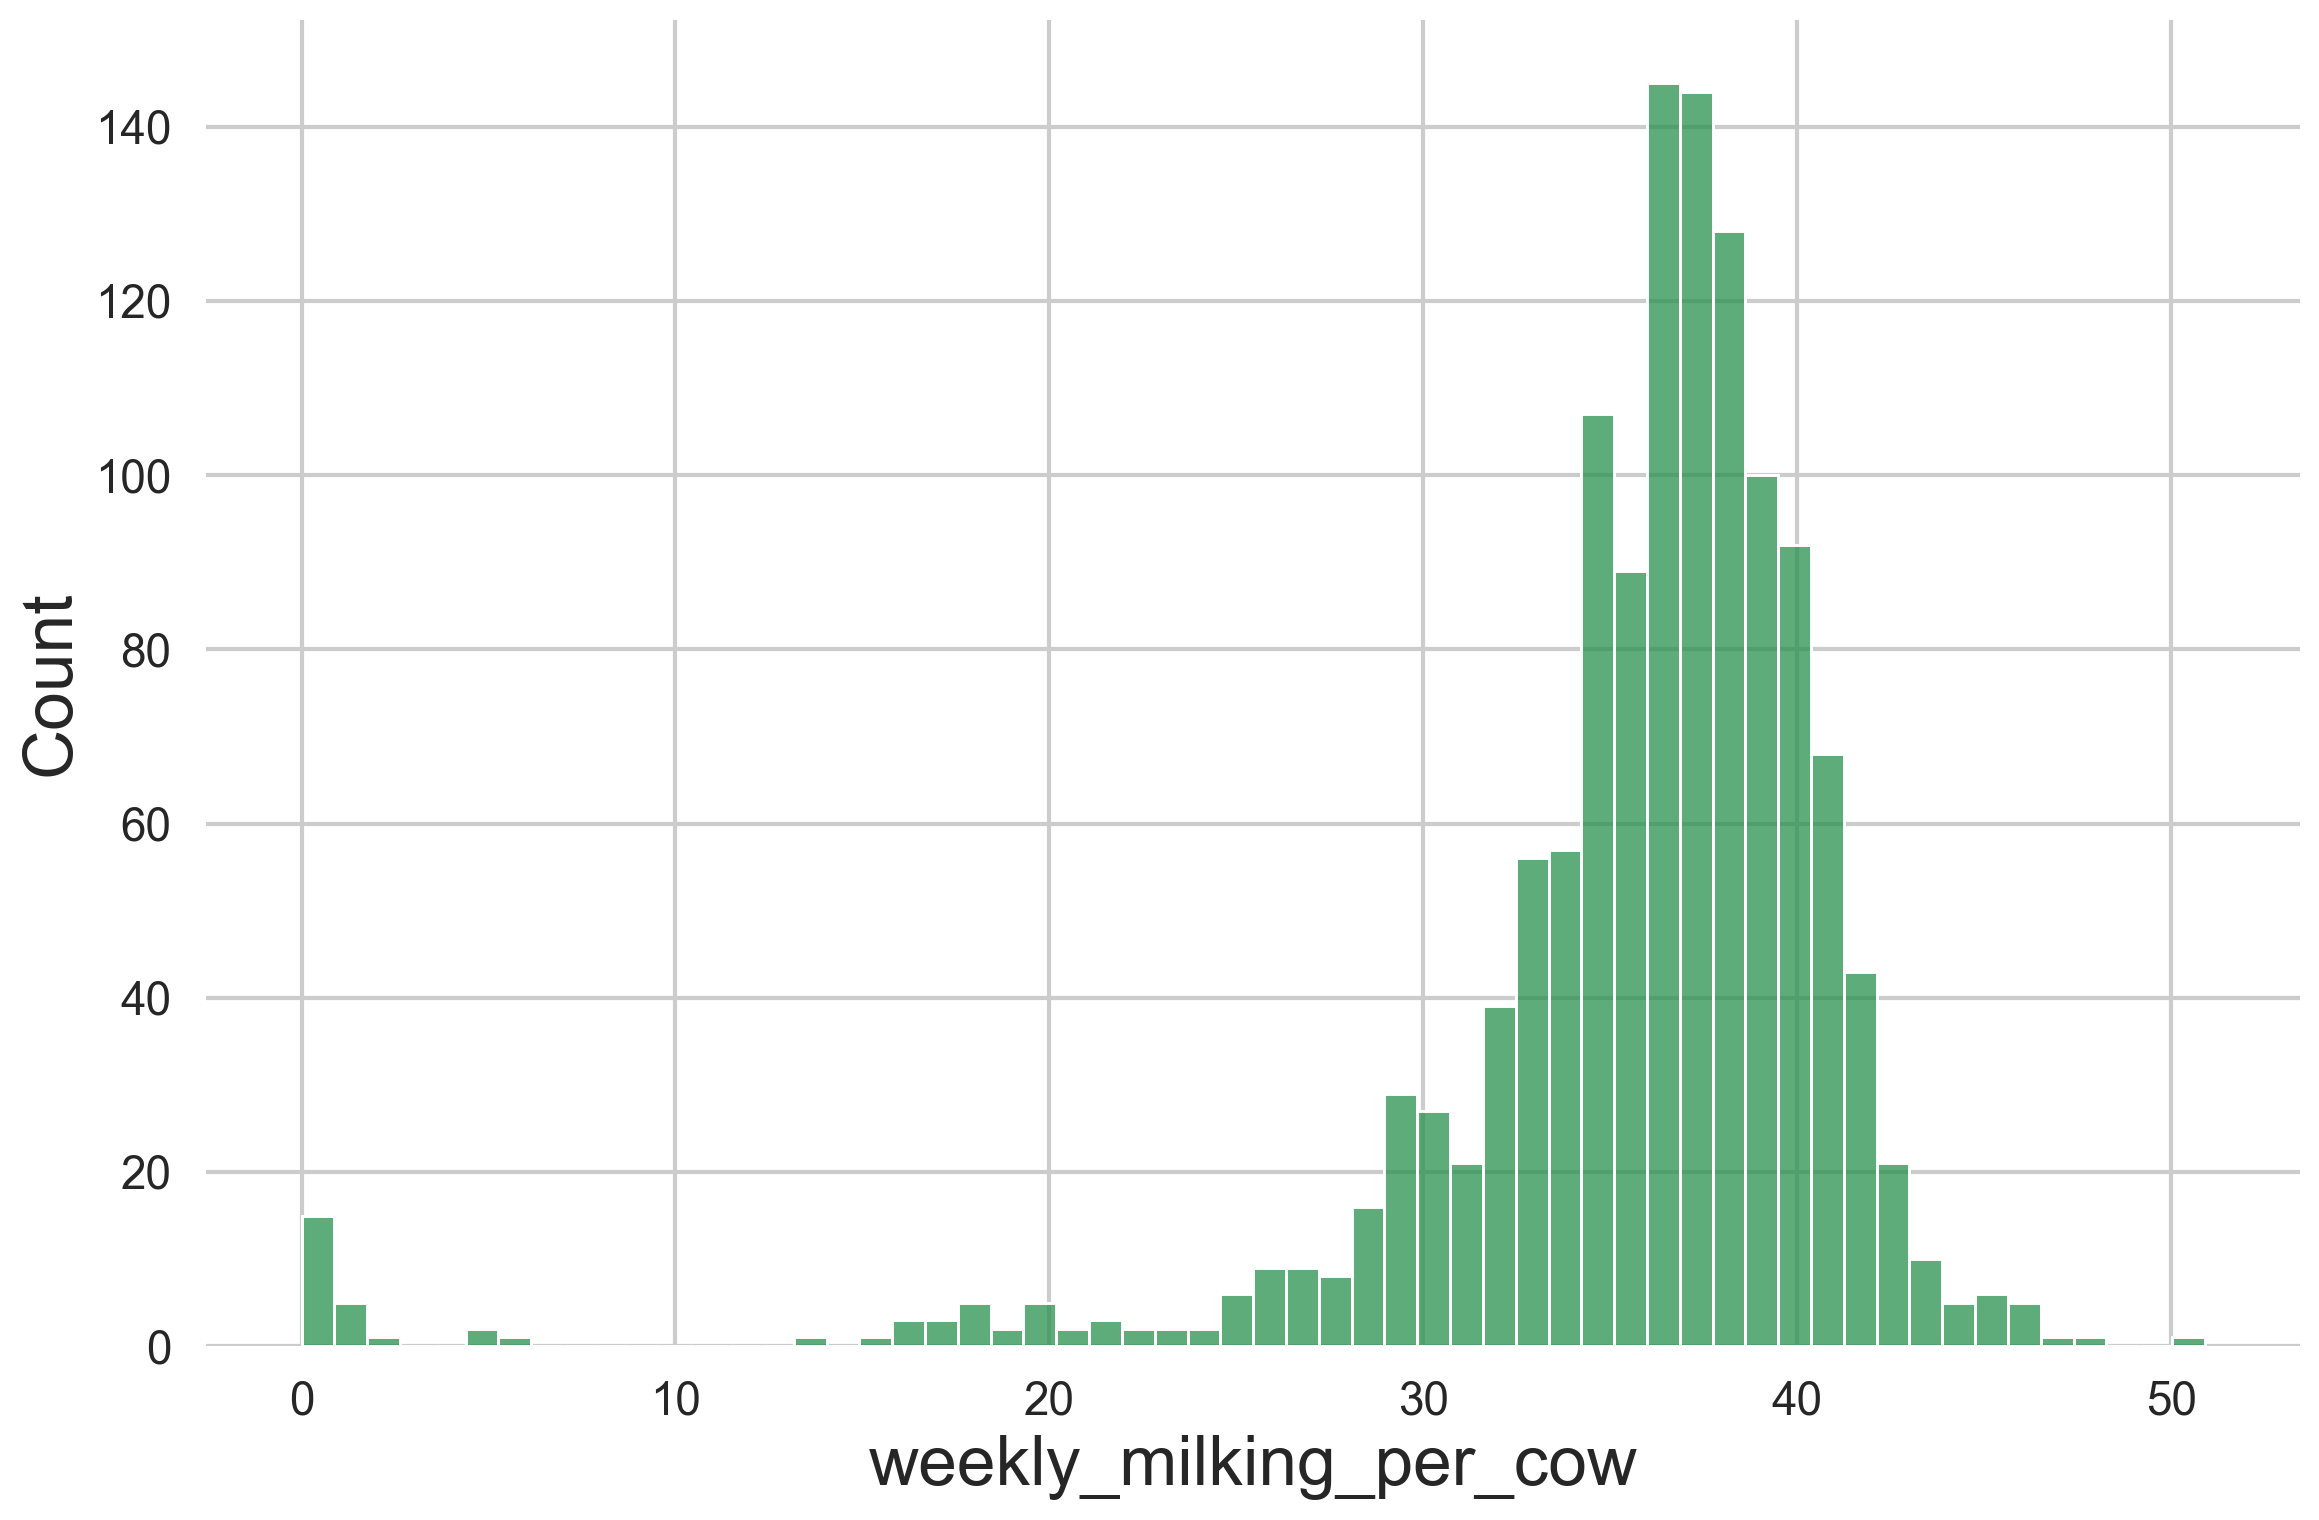

In [21]:
sns.histplot(production_indicators, x="weekly_milking_per_cow")

In [22]:
herd_milk = herd_metrics[herd_metrics["milk_cow"] > 0]
herd_milk


,date,region,prod_farm_name,farm_type,farm_name,ls_capacity,ls_occupancy,forage_cow,milk_cow,dry_cow,milk_marketab_prc,forcow_milk_yeild,forcow_milk_yeild_stand,milk_fat,milk_protein,somatic_cells,bac_contam,cow_retired,cow_lame,cow_mastits,calves,cow_metrit,ph_urine_avr
0,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров,2800.0,95.535714,2675.0,2329.0,346.0,94.0,NaN,NaN,NaN,NaN,92.0,41.00,52.0,90.0,57,NaN,NaN,NaN
1,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Бобров-2,2800.0,101.678571,2847.0,2378.0,469.0,96.0,NaN,NaN,NaN,NaN,90.0,29.00,30.0,44.0,27,NaN,NaN,NaN
2,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Верхний Икорец,2800.0,101.071429,2830.0,2363.0,467.0,96.0,NaN,NaN,NaN,NaN,161.0,72.00,52.0,57.0,77,NaN,NaN,NaN
3,2020-01-01,Воронеж,ЭНА Восток,ЖК,ЖК Петропавловка,2800.0,59.321429,1661.0,1632.0,29.0,99.0,NaN,NaN,NaN,NaN,69.0,8.00,35.0,120.0,26,NaN,NaN,NaN
4,2020-01-01,Воронеж,ЭНА Восток,МТФ,МТФ Владимировка,467.0,37.473233,175.0,175.0,0.0,96.0,NaN,NaN,NaN,NaN,259.0,58.00,17.0,2.0,10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Борково,2750.0,93.000000,2561.0,2405.0,156.0,97.0,33.78,36.0,4.0,3.4,96.0,33.00,97.0,102.0,48,NaN,NaN,NaN
4296,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Елбань,6200.0,95.000000,5882.0,5468.0,414.0,98.0,32.20,33.9,3.9,3.4,102.5,39.36,526.0,186.0,90,812.0,132.0,5.8
4297,2025-07-01,Сибирь,Сибирская Нива Маслянино,ЖК,ЖК Пеньково,4700.0,99.000000,4666.0,4172.0,494.0,95.0,30.11,31.8,3.9,3.4,114.0,46.00,189.0,305.0,75,843.0,123.0,6.3
4299,2025-07-01,Сибирь,Сибирская Нива Черепаново,ЖК,ЖК Огнева Заимка,3550.0,100.000000,3544.0,3141.0,403.0,94.0,34.95,36.0,3.8,3.3,91.0,38.00,115.0,124.0,47,514.0,131.0,6.5


In [23]:
print(herd_metrics["forcow_milk_yeild"].isna().sum() / herd_metrics.shape[0], herd_metrics["forcow_milk_yeild_stand"].isna().sum() / herd_metrics.shape[0])

0.6168332945826552 0.6168332945826552


### Обновление: оказывается, достаточно много пропусков на объеме молока, в рамках стада - 60%, в рамках фермы - 25%, хз пока что что с этим делать, или забить, или исследовать аппетит

In [24]:
feeding_25

,FeedingTaskID,Date,FarmName,FeedNumber,SectionID,PhysiologicalGroupID,PhysiologicalGroupName,PhysiologicalGroupHeadCount,Appetite,RationName,RationPart,TotalWeight_kg,CompletedAt,year
0,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,4,17,14,Д1,275,1.0,Д1,0.8,11366.0,2025-01-01T10:30:52.9959775,2025
1,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,6,10,14,Д1,306,0.9,Д1,0.8,11075.0,2025-01-01T09:18:28.5568200,2025
2,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,5,21,14,Д1,260,1.0,Д1,1.0,11686.0,2025-01-01T08:33:33.8061927,2025
3,Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...,2025-01-01,ЖК Бортниково,5,55,5,Д1,296,1.1,Д1 (Лактация 1),0.5,8997.0,2025-01-01T10:23:00.0000000,2025
4,Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...,2025-01-01,ЖК Бортниково,4,47,5,Д1,293,1.0,Д1 (Лактация 1),0.5,8574.0,2025-01-01T09:23:00.0000000,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586831,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,16,1,3,Д1,139,1.1,Д1,0.6,5476.0,2025-10-22T08:30:28.0916260,2025
586832,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,17,14,7,С1,37,1.2,С1,1.0,1390.0,2025-10-22T08:53:57.7488136,2025
586833,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,18,139,7,С1,37,1.3,С1,1.0,1435.0,2025-10-22T08:53:09.7102933,2025
586834,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,19,103,7,С1,37,1.4,С1,1.0,1601.0,2025-10-22T08:51:09.2068847,2025


<Axes: xlabel='Appetite', ylabel='count'>

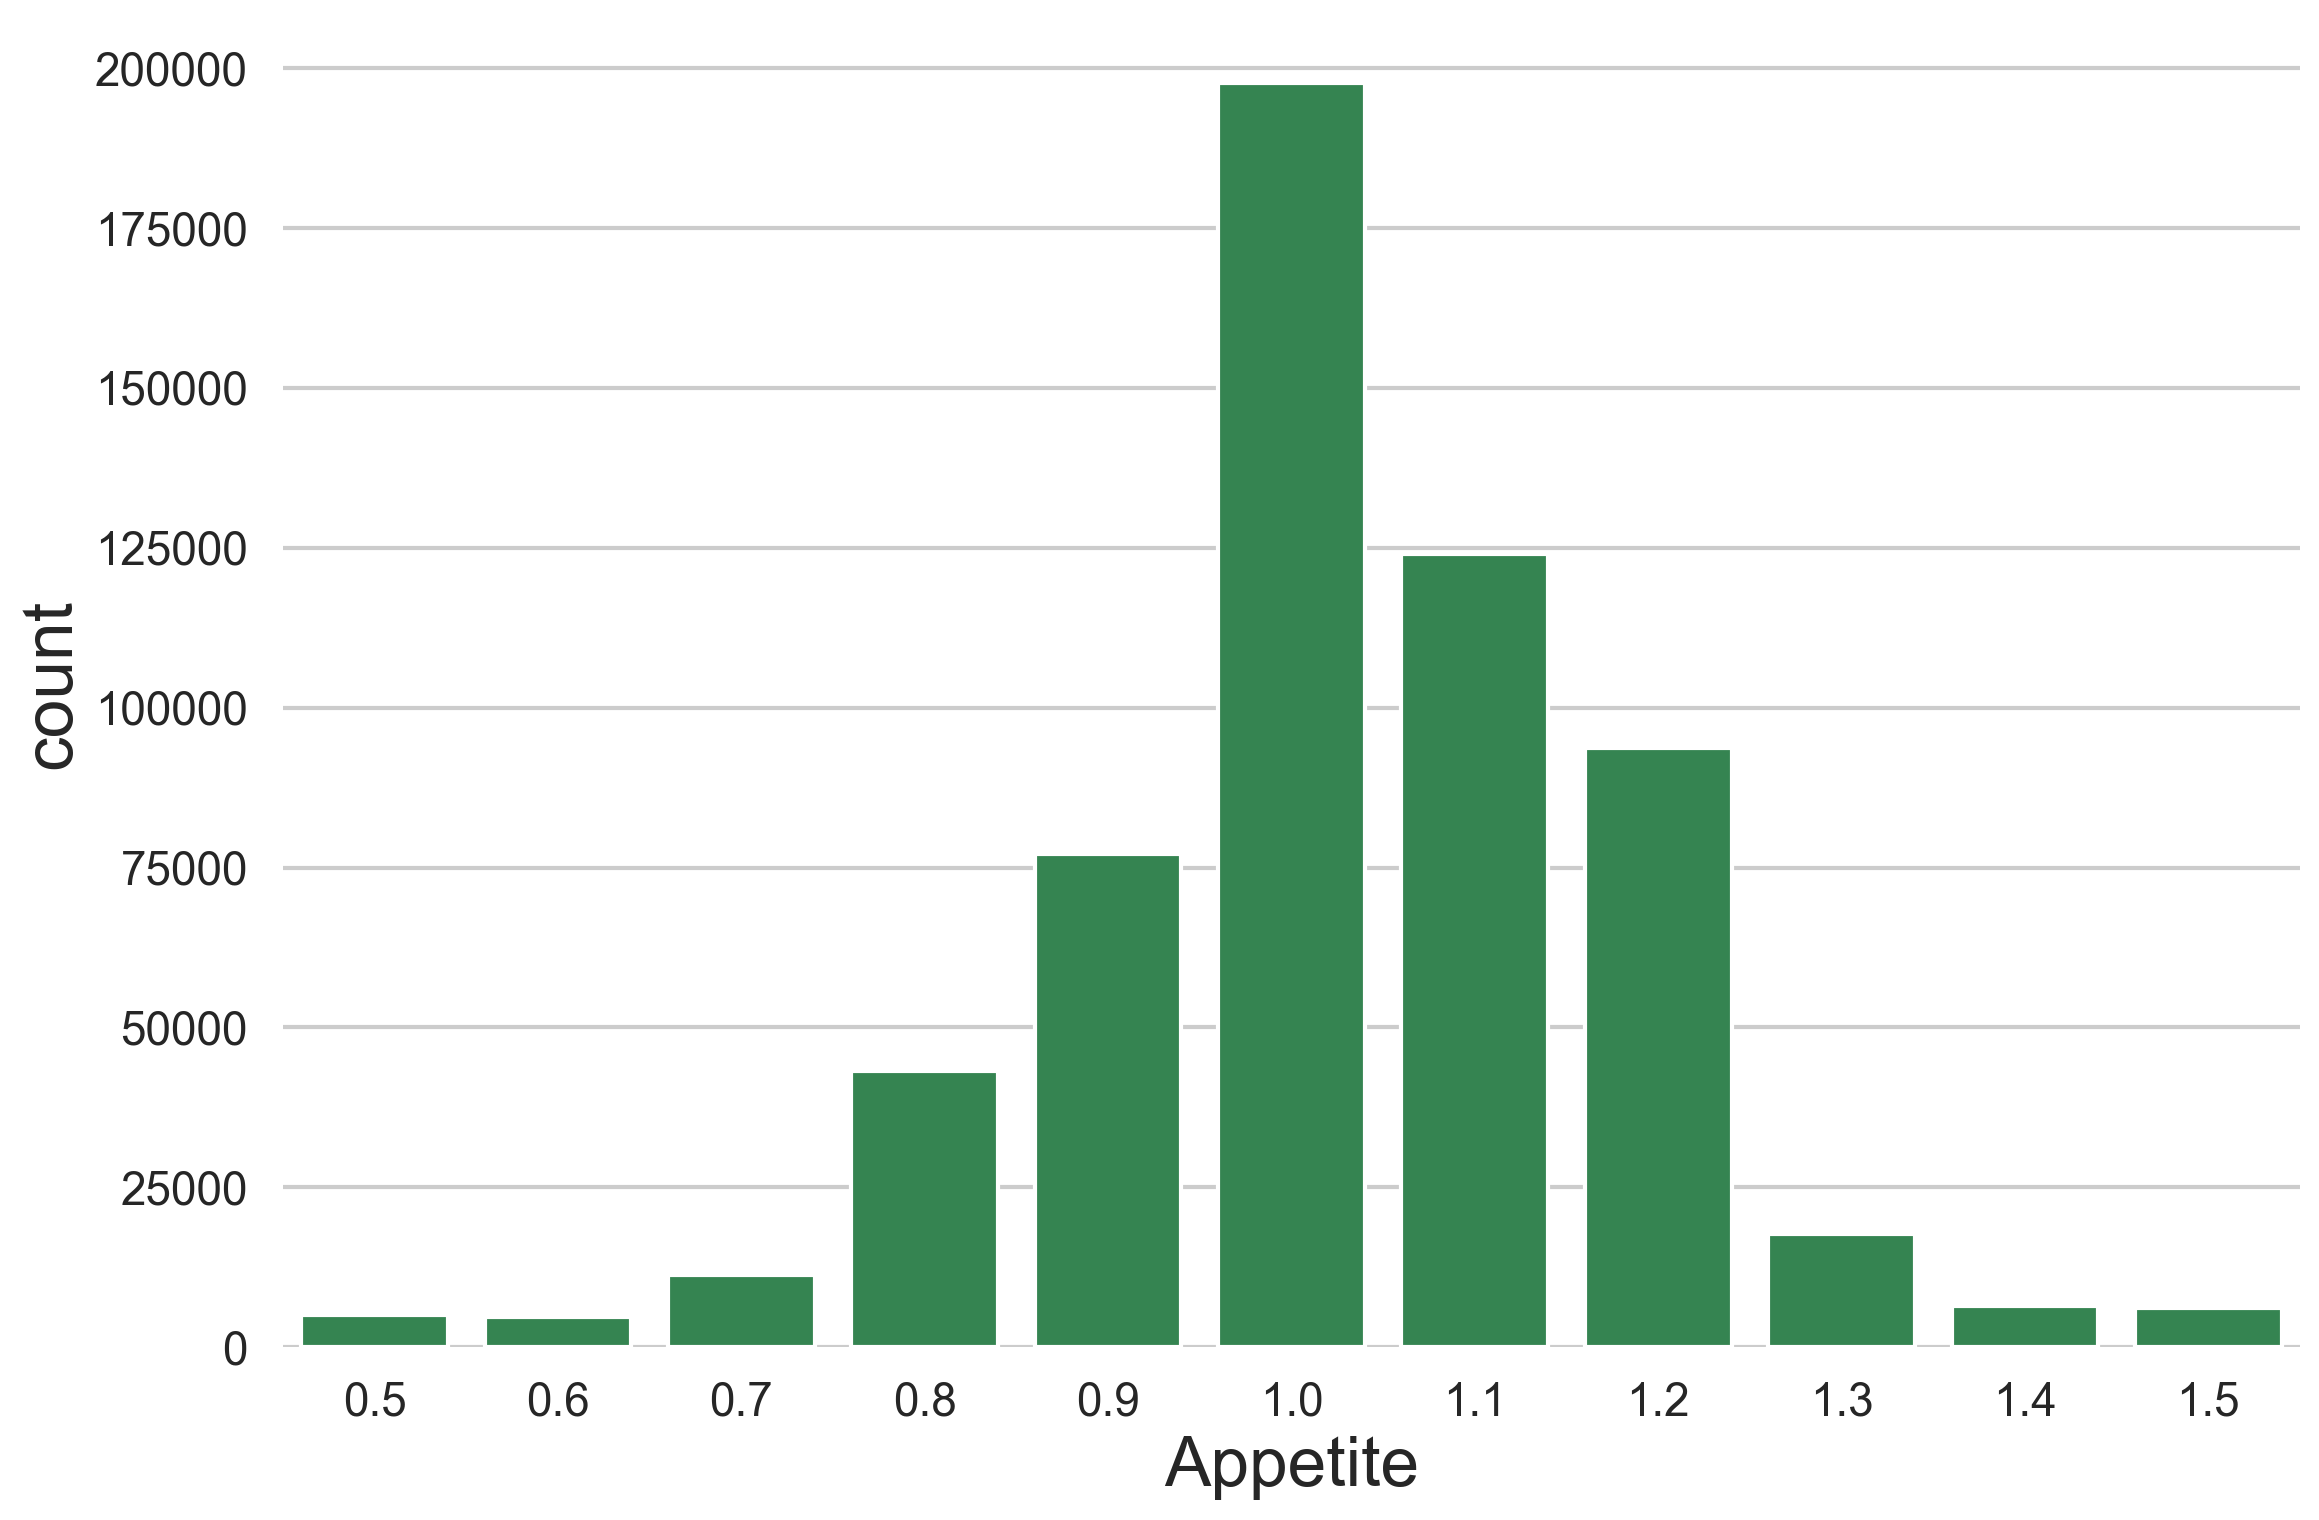

In [25]:
sns.countplot(feeding_25, x="Appetite")

In [26]:
feeding_25["Appetite"].isna().sum() / feeding_25.shape[0]

np.float64(0.0)

## Это хорошо, но все еще не понимаю как это связать

<Axes: xlabel='milk_marketab_prc', ylabel='Count'>

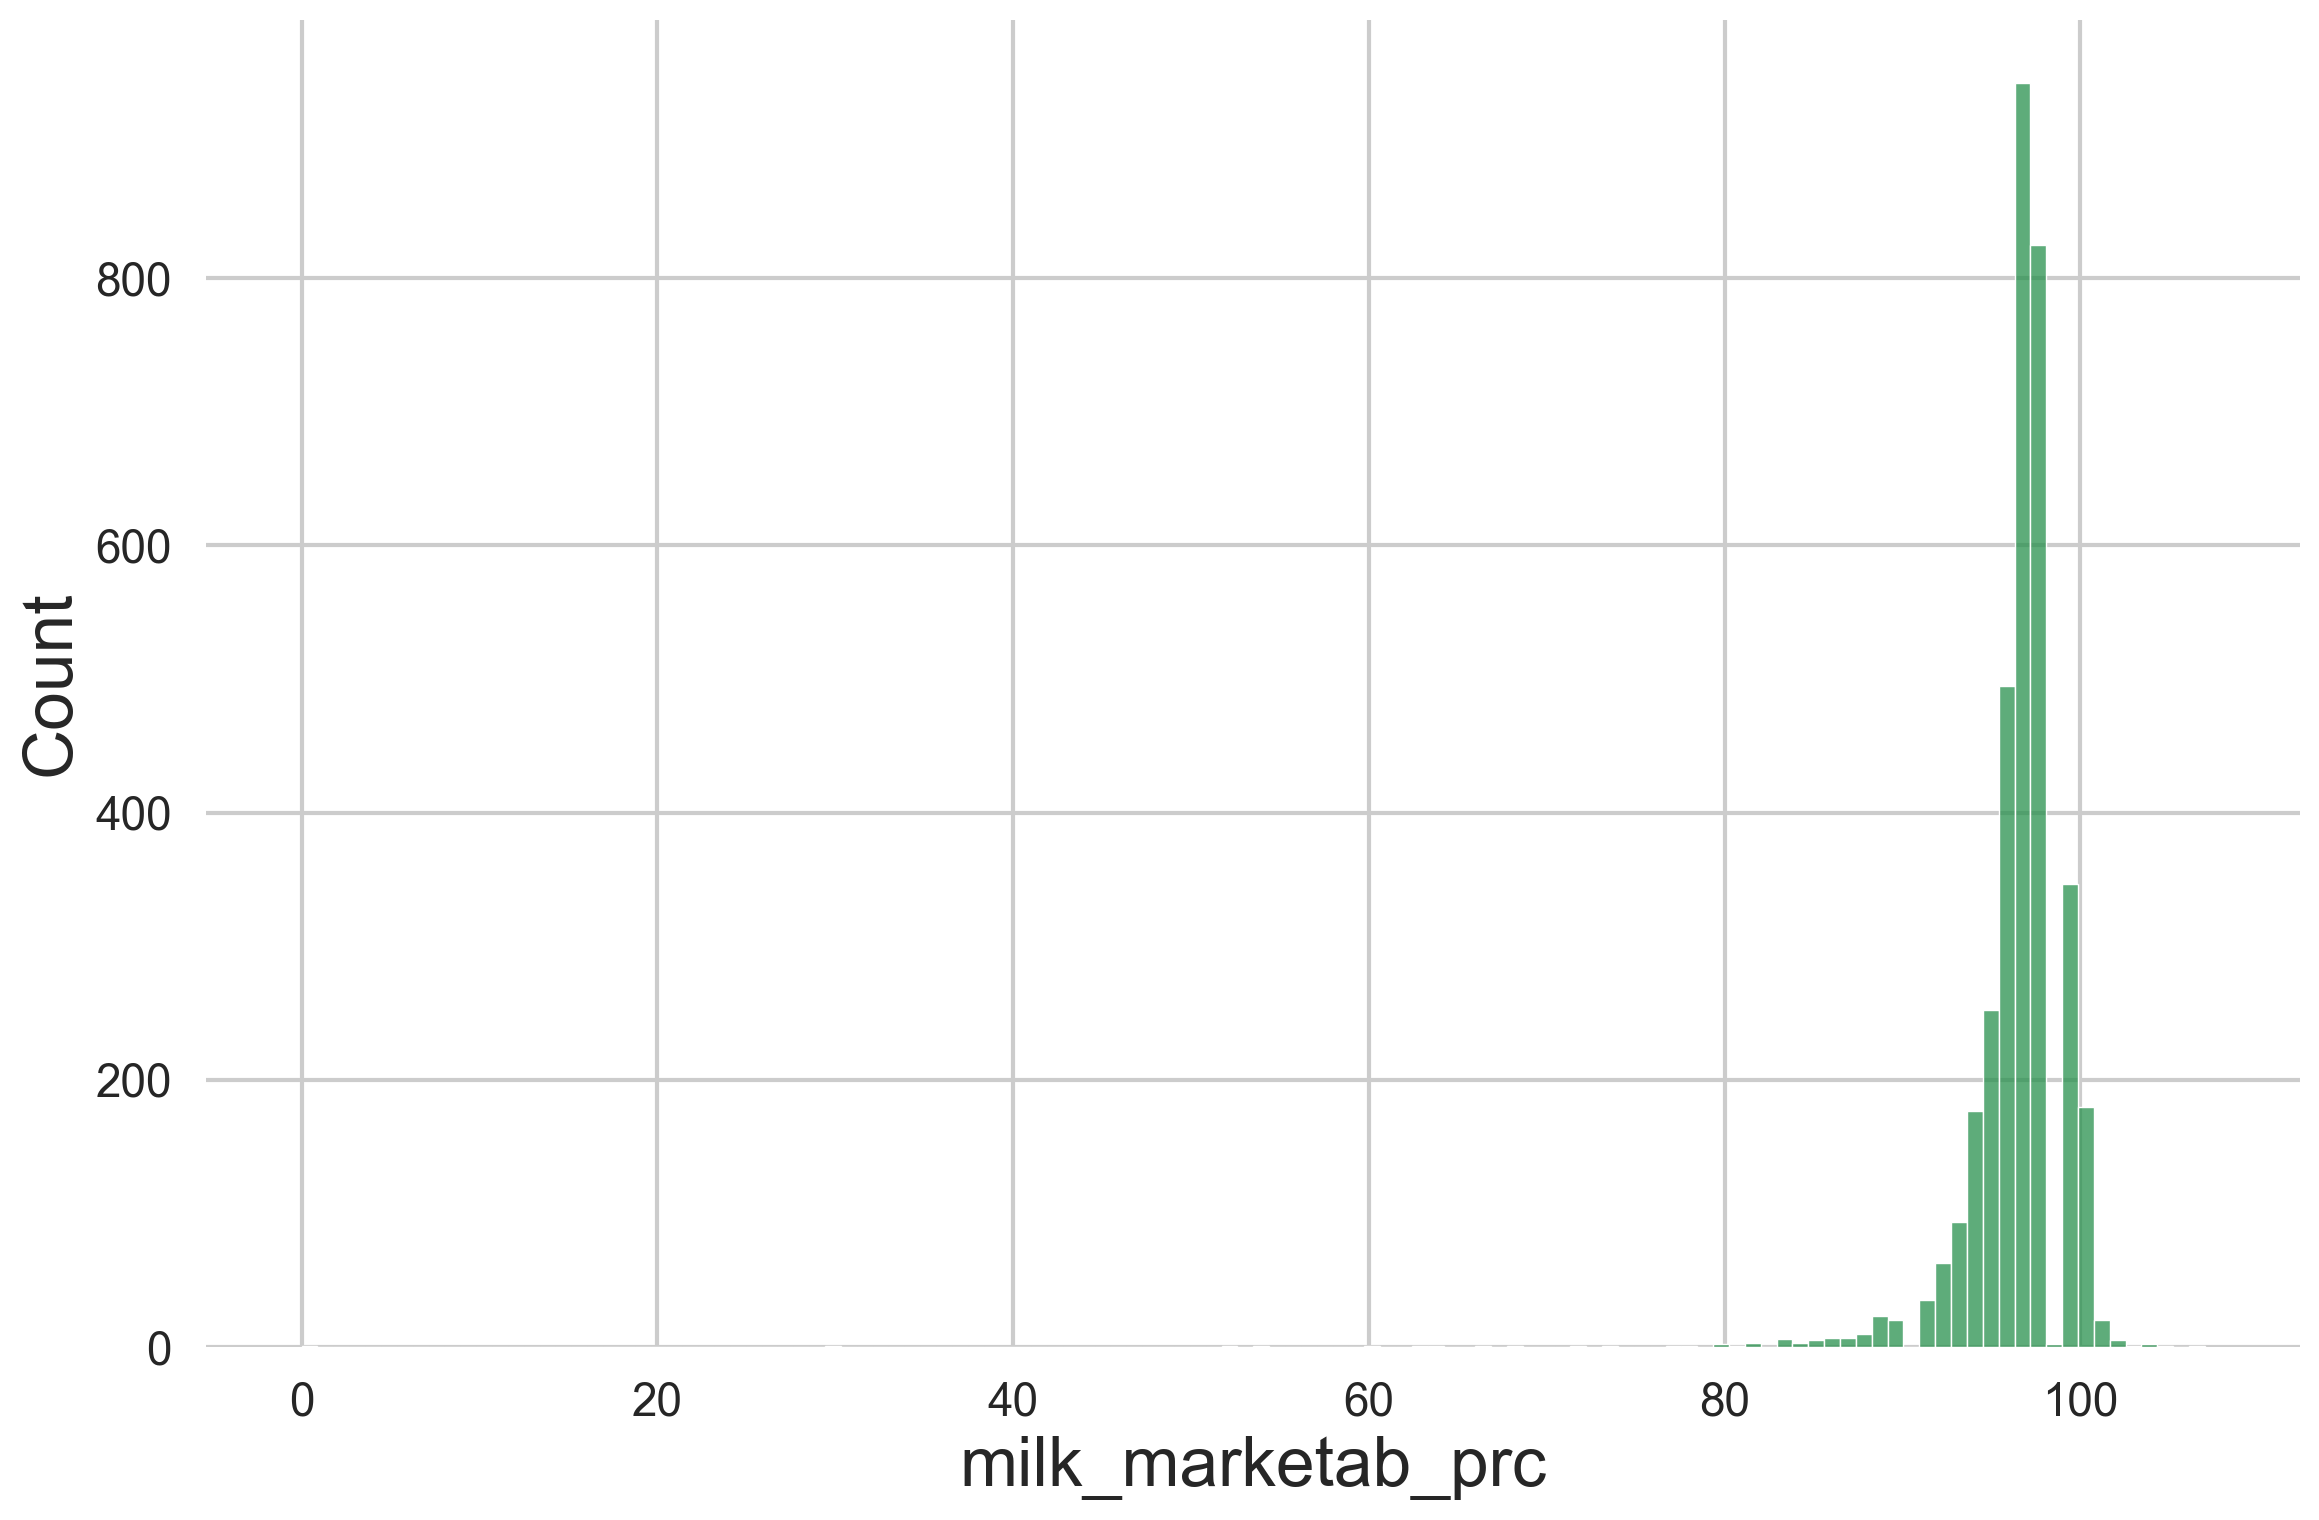

In [27]:
sns.histplot(herd_metrics, x="milk_marketab_prc")

In [28]:
feeding_25["RationName"].unique()

array(['Д1', 'Д1 (Лактация 1)', 'Н', 'T1', 'T2', 'Д3', 'С2', 'С2 нетели',
       'Д0', 'T4', 'Д2', 'Т3', 'Нетели', 'С2 Нетели', 'С1',
       'Т0 вне миксера', 'Н Нетели', 'д3 остатки', 'Т0 Б0 вне миксера',
       'Д1 КК11', 'Т2 6-8', 'Т0 ( Вне миксера )', 'Т0  0-2   вне миксера',
       'D1', 'Т3 Тлк 9-12', 'Т4 Тлк 13-20', 'Т2 Тлк 6-8', 'Т1 Тлк 3-5',
       'Нeтели', 'Т1 Комбикорм вне миксера', 'T0 вне миксера', 'C1',
       'НТ Нетели', 'Т3 9-12', 'Т1-2 3-8', 'D2', 'D0', 'Т0 (Вне миксера)',
       'Нетели вне миксера', 'ПД1', 'Нетели Загон', 'Д3 вне миксера',
       'Т 0 вне миксера', 'Т1 вне миксера', 'Б 0 вне миксера', 'Д1 КК 10',
       'Д1 кк11', 'Т1 3-5', 'Б-0 (вне миксера)', 'т-0 (вне миксера)',
       'Навес к/к(вне миксера)', 'Т4 13-20', 'д-1', 'д-3 (Вне миксера)',
       'Н (Нетели)', 'Т1 (вне миксера)', 'Б0 (вне миксера)',
       'Т0 (вне миксера)', 'нетели', 'Т4', 'Т1', 'Т2', 'T1 (Вне миксера)',
       'Т2 (6-8 мес)', 'Т1 (3-5 мес)', 'Т3 (9-12 мес)', 'Т4 (13-20 мес)',
     

In [29]:
monthly_feeding["feed_name"].unique()

array(['Биотек Микс', 'Добавка кормовая Бустер Милк',
       'Добавка кормовая Кальвобустер', 'Добавка кормовая Кальволит',
       'ЗЦМ "НЭОМИЛК"', 'ЗЦМ Евролак Turbo',
       'Комбикорм №4 КН Восток (покупной)',
       'Комбикорм гранула для телят "Престартер" (Каргилл)',
       'Комбикорм для телят (покупной)',
       'Комбикорм КК 62 для телят 0-3 мес', 'Молоко',
       'Молоко (Корма покупные)', 'Молоко сухое', 'Престартер (покупной)',
       'Провилит', 'Жом сухой', 'Комбикорм №3 КН Восток (покупной)',
       'Кукуруза фуражная (покупная) подработанная', 'Сенаж покупной',
       'Силос покупной', 'Шрот соевый', 'Актисаф HR+ (кормовая добавка)',
       'Глицерин кормовой', 'Дробленое зерно (кукуруза)',
       'Дробленое зерно (кукуруза) (покупное)',
       'Дробленое зерно (пшеница)', 'Дробленое зерно (ячмень)',
       'Дробленое зерно (ячмень) (покупное)',
       'Жир защищенный (Нутракор, Максимайзер, Оптима,Палмак)',
       'Жир растительный сухой ULTRA FEED F', 'Жмых рапсовый',

## Вопрос 1: Что за пресеты в monthly _feeding? это есть еще где-то?

In [30]:
display(feeding_25, feeding_details_25)

,FeedingTaskID,Date,FarmName,FeedNumber,SectionID,PhysiologicalGroupID,PhysiologicalGroupName,PhysiologicalGroupHeadCount,Appetite,RationName,RationPart,TotalWeight_kg,CompletedAt,year
0,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,4,17,14,Д1,275,1.0,Д1,0.8,11366.0,2025-01-01T10:30:52.9959775,2025
1,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,6,10,14,Д1,306,0.9,Д1,0.8,11075.0,2025-01-01T09:18:28.5568200,2025
2,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,2025-01-01,ЖК Пеневичи,5,21,14,Д1,260,1.0,Д1,1.0,11686.0,2025-01-01T08:33:33.8061927,2025
3,Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...,2025-01-01,ЖК Бортниково,5,55,5,Д1,296,1.1,Д1 (Лактация 1),0.5,8997.0,2025-01-01T10:23:00.0000000,2025
4,Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...,2025-01-01,ЖК Бортниково,4,47,5,Д1,293,1.0,Д1 (Лактация 1),0.5,8574.0,2025-01-01T09:23:00.0000000,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586831,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,16,1,3,Д1,139,1.1,Д1,0.6,5476.0,2025-10-22T08:30:28.0916260,2025
586832,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,17,14,7,С1,37,1.2,С1,1.0,1390.0,2025-10-22T08:53:57.7488136,2025
586833,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,18,139,7,С1,37,1.3,С1,1.0,1435.0,2025-10-22T08:53:09.7102933,2025
586834,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,2025-10-22,ЖК Подболотье,19,103,7,С1,37,1.4,С1,1.0,1601.0,2025-10-22T08:51:09.2068847,2025


,FeedingTaskID,SectionID,PhysiologicalGroupID,PhysiologicalGroupName,IngredientID,IngredientName,IngredientType,PhysicalWeight_kg,year
0,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,17,14,Д1,57,5210.03.08.01.1.23,Forage,2415.000,2025
1,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,17,14,Д1,105,Карнаж (общ.),Forage,1260.000,2025
2,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,17,14,Д1,96,5210.07.05.02.1.24,Forage,3790.000,2025
3,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,17,14,Д1,0,Вода,Water,715.000,2025
4,Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...,10,14,Д1,57,5210.03.08.01.1.23,Forage,2360.000,2025
...,...,...,...,...,...,...,...,...,...
4356426,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,131,1,Нетели,119,Солома (общ.),Forage,120.643,2025
4356427,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,131,1,Нетели,335,6203.01.01.01.1.25,Forage,549.169,2025
4356428,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,131,1,Нетели,331,Жом свекловичный сухой,Concentrate,36.676,2025
4356429,Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...,131,1,Нетели,143,Премикс молодняк 6-24,VitaminMineral,10.049,2025
